In [1]:

import torch
from torch import nn, optim
import torchvision
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda')

In [4]:
transform = transforms.Compose([
    transforms.Resize(32),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalizing image
    ])

data_dir ='archive/birds'


train_data = ImageFolder(data_dir+'/train',transform = transform)
valid_data = ImageFolder(data_dir+'/valid',transform = transform)
test_data = ImageFolder(data_dir+'/test',transform = transform)

train_loader = DataLoader(dataset=train_data,batch_size = 64,shuffle = True )
valid_loader = DataLoader(dataset=valid_data,batch_size = 64 ,shuffle = True)
test_loader = DataLoader(dataset=test_data,batch_size = 64 ,shuffle = True)


In [5]:
import os

classes = os.listdir("archive/birds/train")
classes.sort()
classes
len(classes) 

275

In [6]:
images, labels = next(iter(train_loader)) 
print(images.shape)

torch.Size([64, 3, 32, 32])


In [7]:
def imshow(img):
    # img = img.numpy()
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))

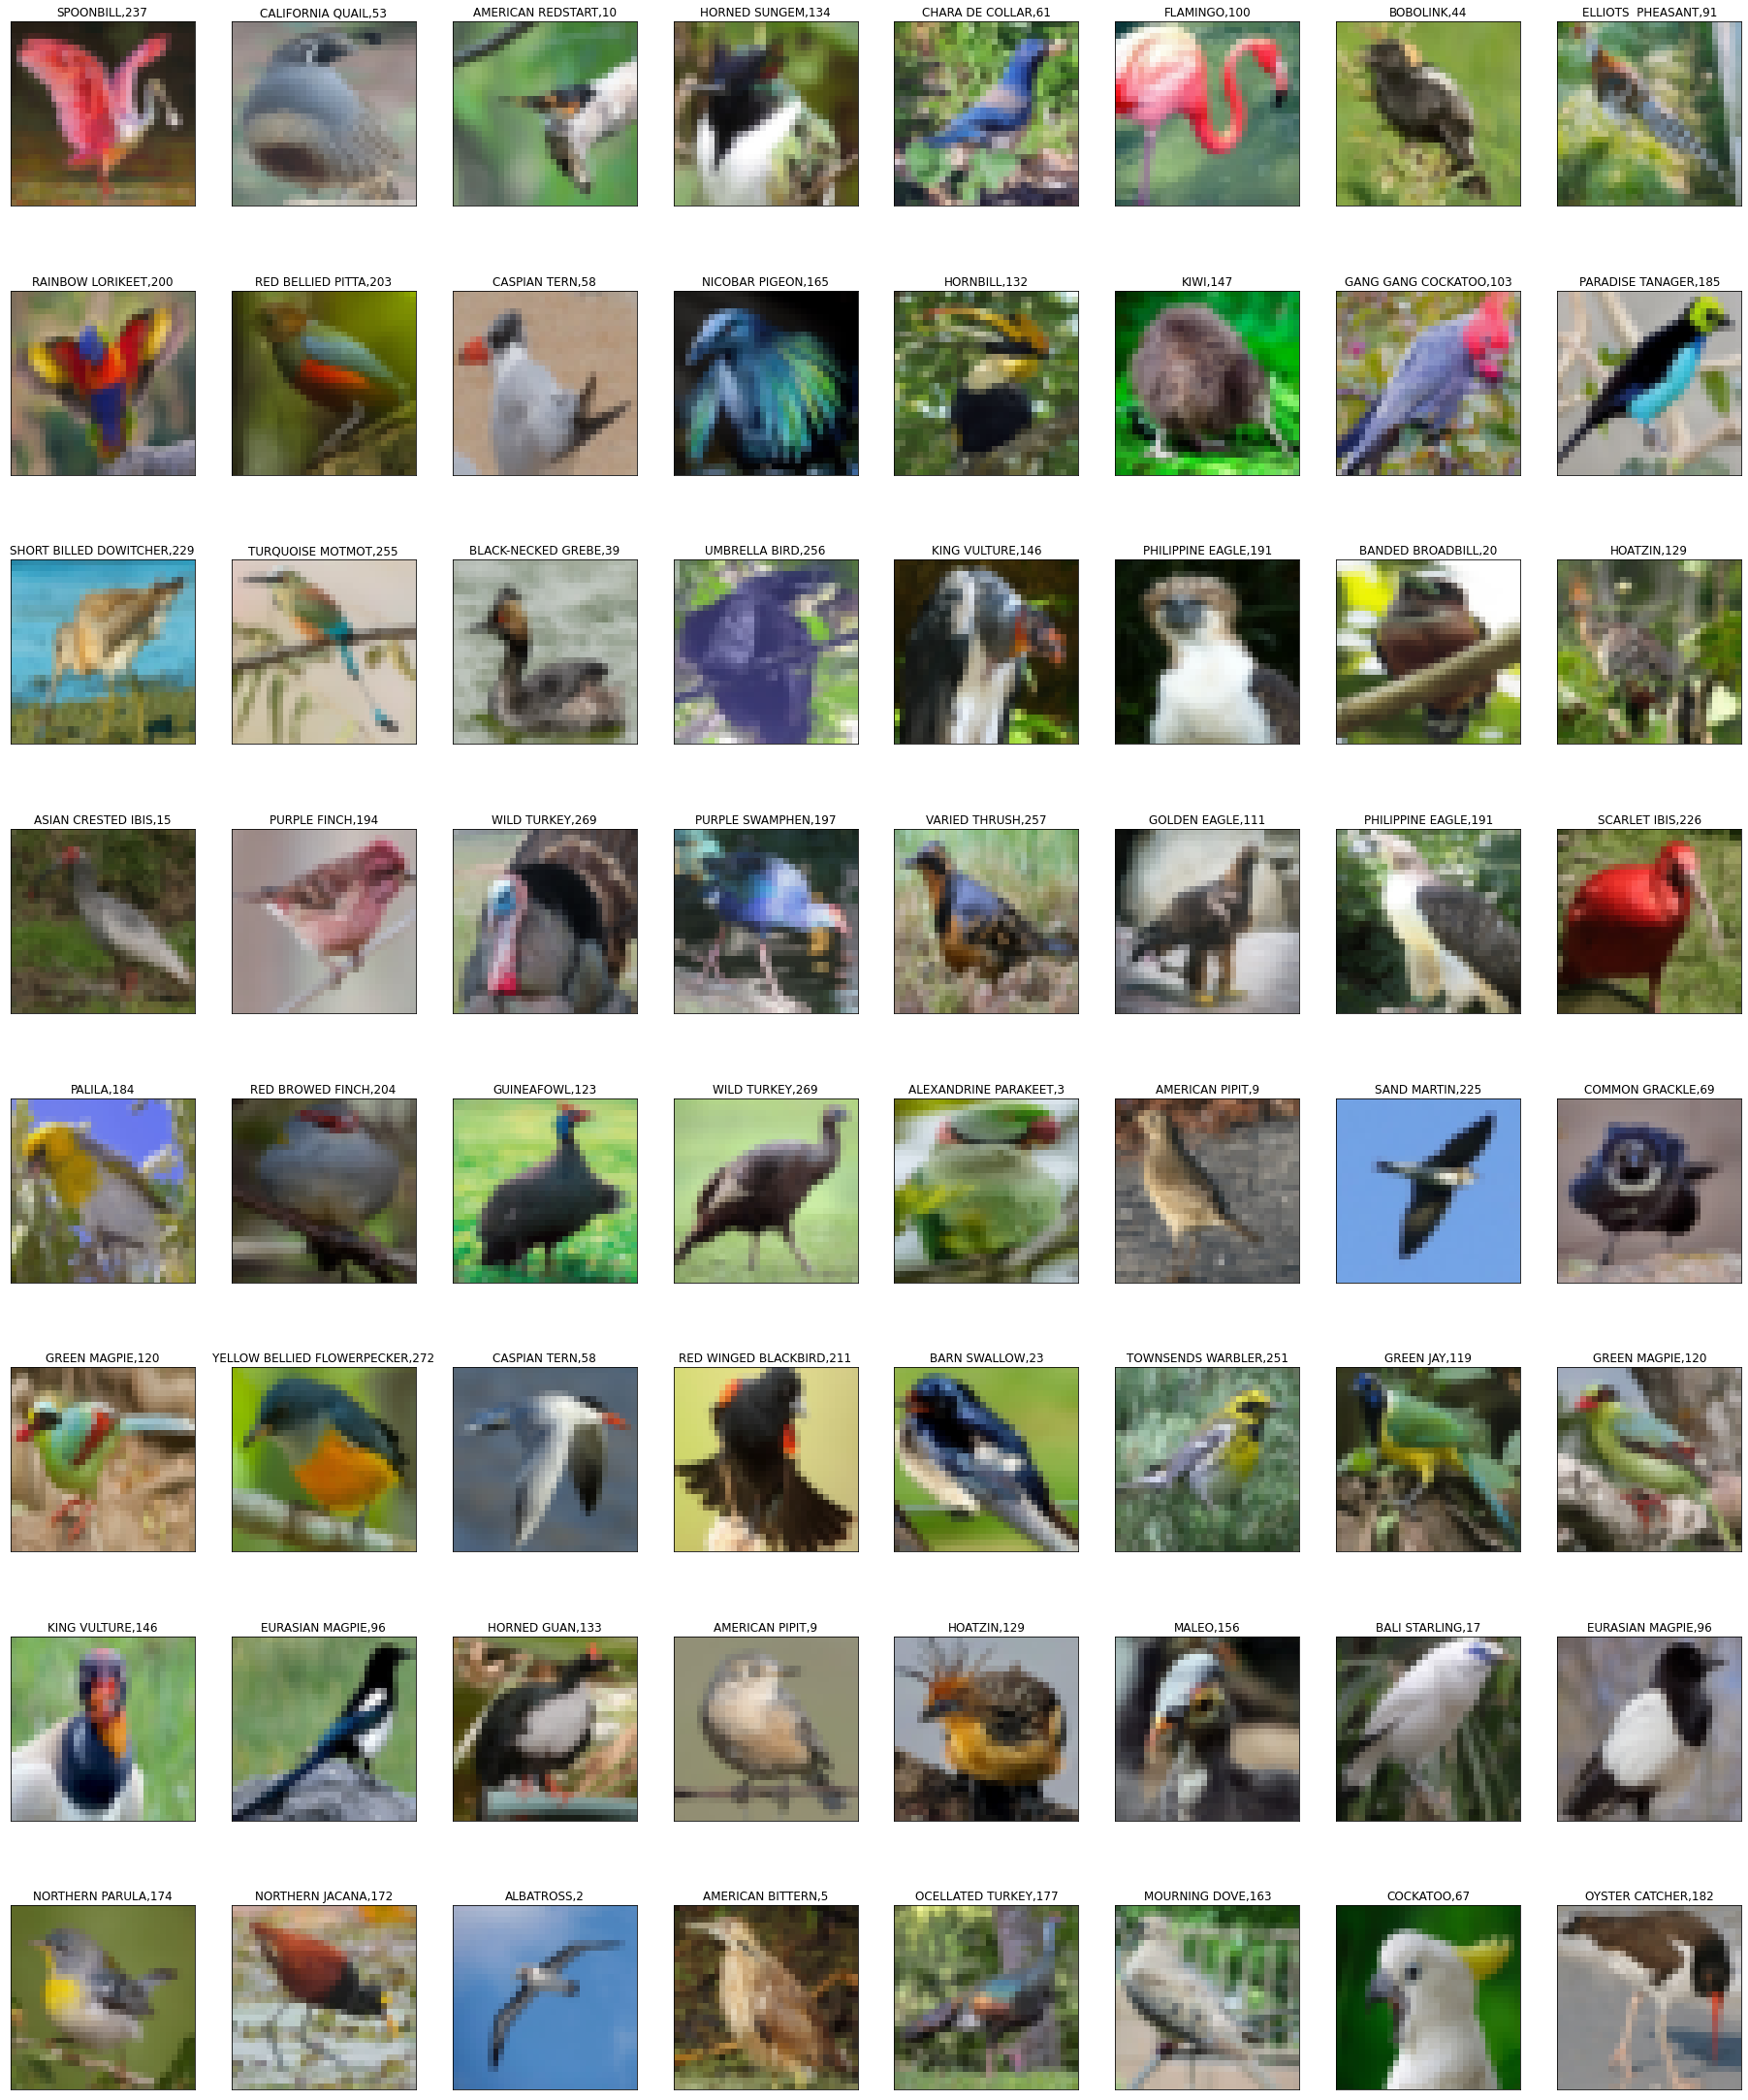

In [8]:
fig = plt.figure(figsize = (32, 40))

for i in range(64):
    subplt = fig.add_subplot(8, 8, i+1, xticks=[], yticks=[])
    
    #Un-normalising image
    img = images[i]/2 + 0.5 
    
    #plotting image
    plt.imshow(np.transpose(img, (1, 2, 0)))
    subplt.set_title(f"{classes[labels[i]]},{labels[i]}")

In [9]:
class ConvNet(nn.Module):
    def __init__(self):
        
        super(ConvNet, self).__init__()
        self.block = nn.Sequential(
            
            nn.Conv2d(3, 6, 5), # in_channels, out_channels, kernel_size, stride, padding
            nn.MaxPool2d(2, 2), # kernel_size, stride

            nn.Conv2d(6, 16, 5), 
            nn.MaxPool2d(2, 2),
            
        )
        
        self.block2 = nn.Sequential(
            
            nn.Linear(16 * 5 * 5, 64),
            nn.ReLU(),

            nn.Linear(64, 300),
            nn.ReLU(),

            nn.Linear(300, 275),
            nn.ReLU(),
            
        )
        
    def forward(self, x):
        y = self.block(x)
        y = y.view(x.shape[0], -1) 
        y = self.block2(y)
        return y

In [10]:
model = ConvNet().cuda()
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.SGD(model.parameters(), lr = 0.05, )
epochs = 60

In [11]:
train_losses = []
val_losses = []

for i in range(epochs):
    total_loss, correct, val_total_loss, val_correct = 0,0,0,0
    for x, y in train_loader:
        
        x = x.cuda()
        y = y.cuda()
        
        pred = model(x)
        loss = loss_fn(pred , y)
        total_loss += loss.item() #Adding loss of each batch
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
        _, predicted = torch.max(pred, 1) #Getting the index with max probability
        correct += (predicted == y).sum().item()
        
    model.eval()    
    for x, y in valid_loader:
        
        x = x.cuda()
        y = y.cuda()
        
        pred = model(x)
        loss = loss_fn(pred , y)
        val_total_loss += loss.item() #Adding loss of each batch
        
        _, predicted = torch.max(pred, 1) #Getting the index with max probability
        val_correct += (predicted == y).sum().item()
        
    total_loss /= len(train_loader.dataset) # average of total loss of all batches
    train_losses.append(total_loss) #Collecting loss of each epoch for plotting graph
    
    val_total_loss /= len(valid_loader.dataset) # average of total loss of all batches
    val_losses.append(val_total_loss) #Collecting loss of each epoch for plotting graph
    
    correct /= len(train_loader.dataset)
    val_correct /= len(valid_loader.dataset)
    
    print(f"[=============Epochs: {i+1} ============]")
    print(f"Train_Loss : {total_loss:.5f}")
    print(f"Train_Accuracy : {correct:.5f}")
    print('')
    print(f"Valid_Loss : {val_total_loss:.5f}")
    print(f"Valid_Accuracy : {val_correct:.5f}")

C:\Users\GAURAV\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[=============Epochs: 1 ============]
Train_Loss : 0.08783
Train_Accuracy : 0.00719

Valid_Loss : 0.08959
Valid_Accuracy : 0.00364
[=============Epochs: 2 ============]
Train_Loss : 0.08608
Train_Accuracy : 0.01448

Valid_Loss : 0.09109
Valid_Accuracy : 0.00873
[=============Epochs: 3 ============]
Train_Loss : 0.08214
Train_Accuracy : 0.03524

Valid_Loss : 0.09176
Valid_Accuracy : 0.02255
[=============Epochs: 4 ============]
Train_Loss : 0.07562
Train_Accuracy : 0.08063

Valid_Loss : 0.10530
Valid_Accuracy : 0.02618
[=============Epochs: 5 ============]
Train_Loss : 0.06836
Train_Accuracy : 0.14076

Valid_Loss : 0.09317
Valid_Accuracy : 0.08727
[=============Epochs: 6 ============]
Train_Loss : 0.06115
Train_Accuracy : 0.20270

Valid_Loss : 0.08387
Valid_Accuracy : 0.11127
[=============Epochs: 7 ============]
Train_Loss : 0.05488
Train_Accuracy : 0.25320

Valid_Loss : 0.09396
Valid_Accuracy : 0.10400
[=============Epochs: 8 ============]
Train_Loss : 0.05005
Train_Accuracy : 0.29951

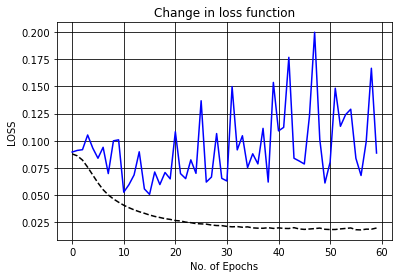

In [12]:
plt.plot(train_losses, 'k--', label = 'train_loss')
plt.plot(val_losses, 'b', label = 'valid_loss')
plt.title("Change in loss function")
plt.xlabel("No. of Epochs")
plt.ylabel("LOSS")
plt.grid(True, color = "k")
plt.show()

In [13]:
classes_correct = np.zeros(275)
classes_sample = np.zeros(275)
correct = 0
test_pred = []
with torch.no_grad():
    
    for x_test, y_test in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        outputs = model(x_test)
        
        _, predicted = torch.max(outputs, 1) 
        correct += (predicted == y_test).sum().item()
        
        for i in range(y_test.shape[0]):
            label = y_test[i]
            pred = predicted[i]
            test_pred.append(pred.item())
            if (pred == label):
                classes_correct[label] += 1
            classes_sample[label] += 1
        
    correct/=len(test_loader.dataset)
    print(f"Total Accuracy: {correct:.5f}")
    print('')
        
    for i in range(275):
        print(f"Accuracy of {classes[i]} : {classes_correct[i]/classes_sample[i]:.5f} ")

Total Accuracy: 0.33891

Accuracy of AFRICAN CROWNED CRANE : 0.00000 
Accuracy of AFRICAN FIREFINCH : 0.60000 
Accuracy of ALBATROSS : 0.00000 
Accuracy of ALEXANDRINE PARAKEET : 0.00000 
Accuracy of AMERICAN AVOCET : 0.40000 
Accuracy of AMERICAN BITTERN : 0.00000 
Accuracy of AMERICAN COOT : 0.20000 
Accuracy of AMERICAN GOLDFINCH : 0.40000 
Accuracy of AMERICAN KESTREL : 0.00000 
Accuracy of AMERICAN PIPIT : 0.40000 
Accuracy of AMERICAN REDSTART : 0.20000 
Accuracy of ANHINGA : 0.40000 
Accuracy of ANNAS HUMMINGBIRD : 0.60000 
Accuracy of ANTBIRD : 0.00000 
Accuracy of ARARIPE MANAKIN : 0.80000 
Accuracy of ASIAN CRESTED IBIS : 0.20000 
Accuracy of BALD EAGLE : 0.20000 
Accuracy of BALI STARLING : 0.20000 
Accuracy of BALTIMORE ORIOLE : 0.80000 
Accuracy of BANANAQUIT : 1.00000 
Accuracy of BANDED BROADBILL : 0.80000 
Accuracy of BAR-TAILED GODWIT : 0.00000 
Accuracy of BARN OWL : 0.00000 
Accuracy of BARN SWALLOW : 0.80000 
Accuracy of BARRED PUFFBIRD : 0.00000 
Accuracy of BAY-BR

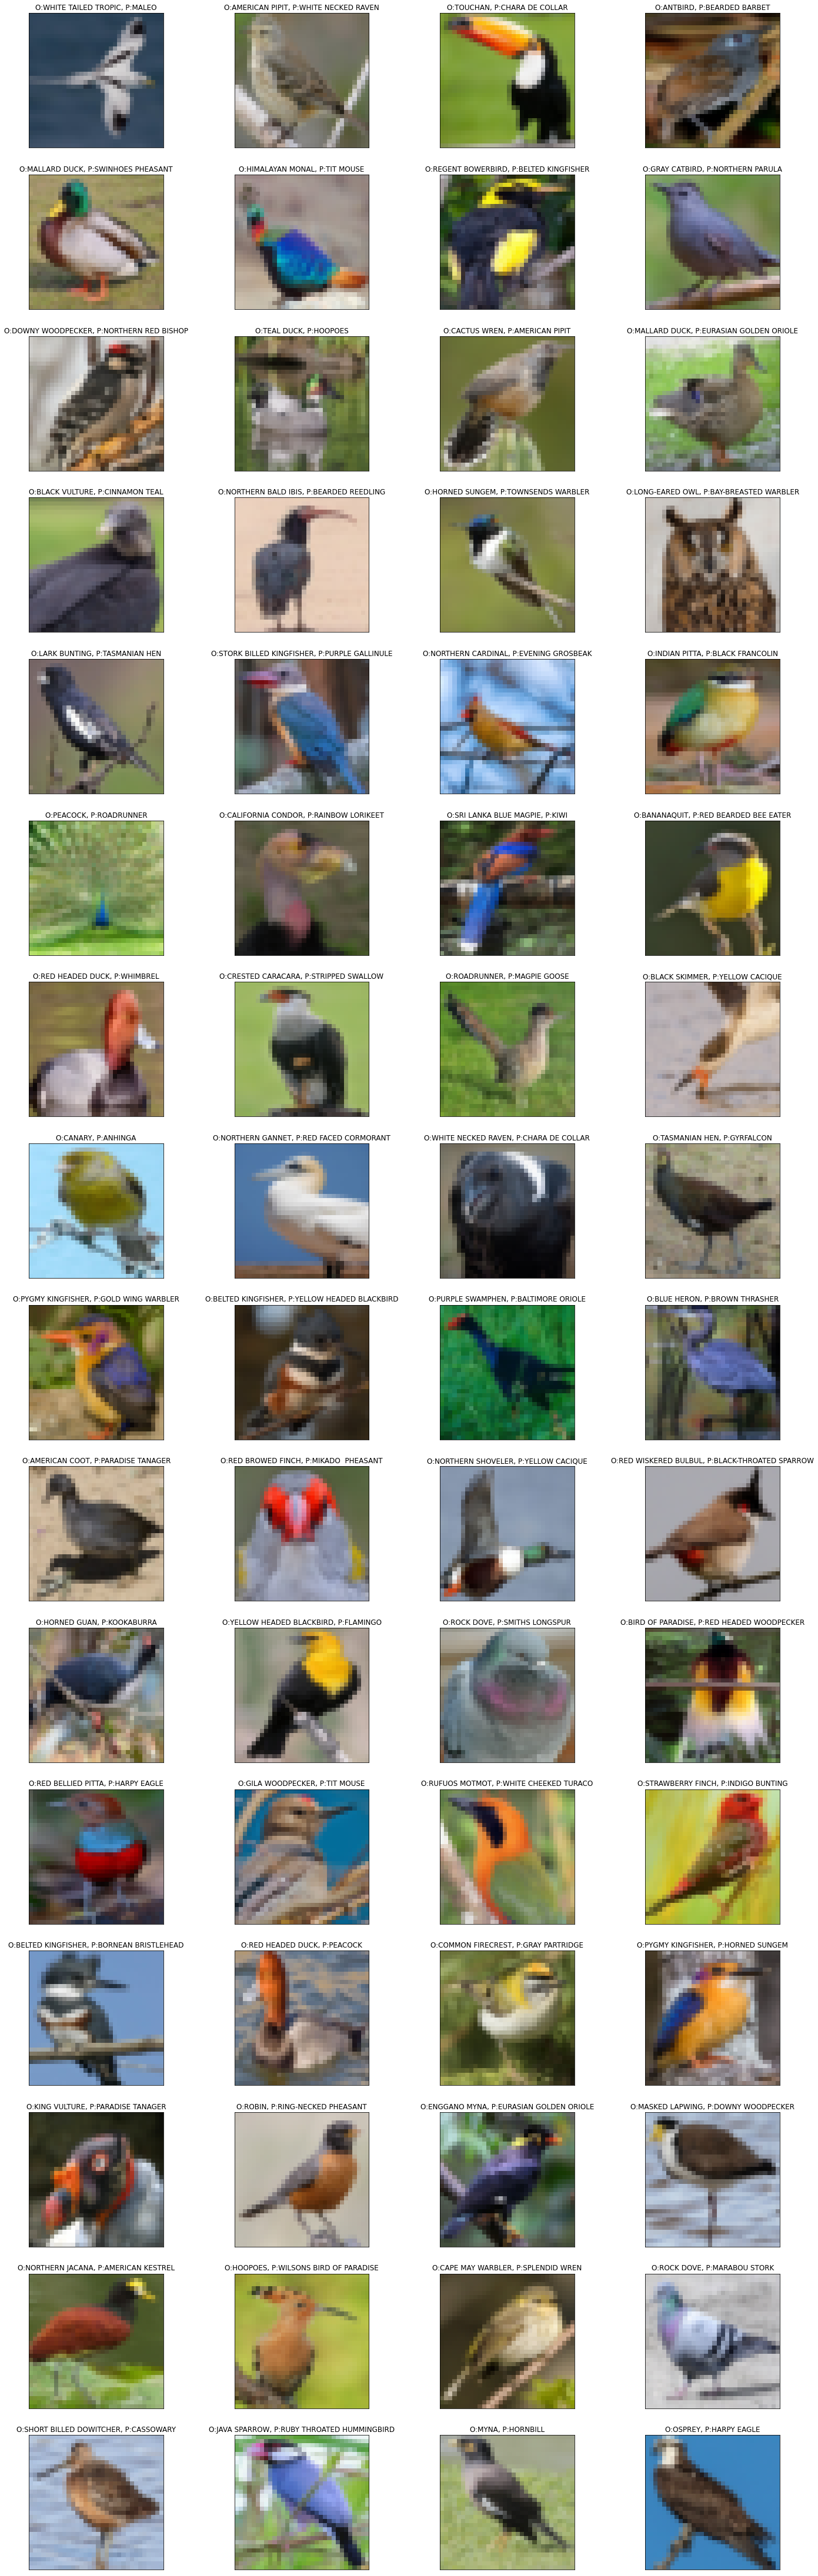

In [14]:
images, labels = next(iter(test_loader))

fig = plt.figure(figsize = (24, 80))

for i in range(64):
    subplt = fig.add_subplot(16,4, i+1, xticks=[], yticks=[])
    img = images[i]/2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))
    subplt.set_title(f"O:{classes[labels[i]]}, P:{classes[test_pred[i]]}")